# Chapter 7 - Ex2: NLP Thời Trang Nam - Comments (Shopee) 

In [1]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix 
from sklearn.model_selection import train_test_split  
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import matplotlib.pyplot as plt
from underthesea import word_tokenize, pos_tag, sent_tokenize
import regex
import string
from Viet_lib import *

***** Dữ liệu đọc ra từ file 'Products_ThoiTrangNam_comments_20K.csv'   
***** Bạn hãy làm phần tiền xử lý liệt kê dưới đây: 
1. Đọc dữ liệu -> dataframe
2. Từ dataframe vừa đọc hãy lọc ra những dữ liệu có số lượng từ trong comment >=7 từ
3. Với kết quả câu trên -> Tạo bộ dữ mới df_sub chỉ gồm 2 cột là 'comment' và 'rating' từ dữ liệu 
4. Xử lý dữ liệu thiếu, dữ liệu trùng trong df_sub
5. Trong df_sub, từ cột 'rating' => tạo cột 'label' theo tiêu chí >=4: 1 (like), <4: 0 (not like)/ hoặc theo tiêu chí: <=2: 3 (not_like), 3: 2 (neutral), >=4: 1 (like)
6. Trong df_sub, từ cột comment -> tạo cột **comment_new** theo các bước đã được hướng dẫn trong phần **Tiền xử lý dữ liệu tiếng Việt** (có thể bổ sung, hiệu chỉnh cho phù hợp với bộ dữ liệu này) để có dữ liệu xử lý.
7. Dùng wordcloud để trực quan hóa dữ liệu 'comment_new' theo từng loại (like/not_like...)
8. Lưu dữ liệu df_sub vào tập tin (ví dụ: "Products_ThoiTrangNam_comments_20K_pre.csv") để thực hiện build model ở phần sau.

#### Chú ý: Các function cần thiết cho việc tiền xử lý dữ liệu Tiếng Việt nên để vào một file Viet_lib.py để gọi sử dụng khi cần

In [2]:
##LOAD EMOJICON
file = open('./input_data/files/emojicon.txt', 'r', encoding="utf8")
emoji_lst = file.read().split('\n')
emoji_dict = {}
for line in emoji_lst:
    key, value = line.split('\t')
    emoji_dict[key] = str(value)
#print(teen_dict)
file.close()
#################
#LOAD TEENCODE
file = open('./input_data/files/teencode.txt', 'r', encoding="utf8")
teen_lst = file.read().split('\n')
teen_dict = {}
for line in teen_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
###############
#LOAD TRANSLATE ENGLISH -> VNMESE
file = open('./input_data/files/english-vnmese.txt', 'r', encoding="utf8")
englist_lst = file.read().split('\n')
for line in englist_lst:
    key, value = line.split('\t')
    teen_dict[key] = str(value)
#print(teen_dict)
file.close()
################
#LOAD wrong words
file = open('./input_data/files/wrong-word.txt', 'r', encoding="utf8")
wrong_lst = file.read().split('\n')
file.close()
#################
#LOAD STOPWORDS
file = open('./input_data/files/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords_lst = file.read().split('\n')
file.close()

In [3]:
df = pd.read_csv('./input_data/data/Products_ThoiTrangNam_comments_20K.csv')

In [4]:
df.head()

,product_id,category,sub_category,user,rating,comment
0,588,Thời Trang Nam,Quần jeans,quyenanh99x,5,chất lượng sản phẩm tốt
1,1333,Thời Trang Nam,Đồ lót,hoai_anh2992,5,", Chất lượng sản phẩm tuyệt vời, Đóng gói sản ..."
2,1671,Thời Trang Nam,Đồ Bộ,r*****5,5,", Chất lượng sản phẩm tuyệt vời"
3,320,Thời Trang Nam,Áo,thanhvui.mt,5,Đóng gói giao hàng nhanh. Chất lượng tốt trong...
4,871,Thời Trang Nam,Đồ lót,t*****8,5,", Đóng gói sản phẩm rất đẹp và chắc chắn"


In [5]:
df.shape

(20000, 6)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   product_id    20000 non-null  int64 
 1   category      20000 non-null  object
 2   sub_category  20000 non-null  object
 3   user          20000 non-null  object
 4   rating        20000 non-null  int64 
 5   comment       20000 non-null  object
dtypes: int64(2), object(4)
memory usage: 937.6+ KB


In [7]:
df.rating.value_counts()

5    10000
4     4000
3     2000
2     2000
1     2000
Name: rating, dtype: int64

In [8]:
df["words"] = [len(x.split(" ")) for x in df['comment']]

In [9]:
df.head()

,product_id,category,sub_category,user,rating,comment,words
0,588,Thời Trang Nam,Quần jeans,quyenanh99x,5,chất lượng sản phẩm tốt,6
1,1333,Thời Trang Nam,Đồ lót,hoai_anh2992,5,", Chất lượng sản phẩm tuyệt vời, Đóng gói sản ...",30
2,1671,Thời Trang Nam,Đồ Bộ,r*****5,5,", Chất lượng sản phẩm tuyệt vời",7
3,320,Thời Trang Nam,Áo,thanhvui.mt,5,Đóng gói giao hàng nhanh. Chất lượng tốt trong...,13
4,871,Thời Trang Nam,Đồ lót,t*****8,5,", Đóng gói sản phẩm rất đẹp và chắc chắn",10


In [10]:
df = df[df["words"]>=7]
df.shape

(16378, 7)

In [11]:
df.rating.value_counts()

5    8911
4    2891
3    1622
1    1605
2    1349
Name: rating, dtype: int64

In [12]:
# Datasub
df_sub = df[['comment', 'rating']]

In [13]:
df_sub.head(5)

,comment,rating
1,", Chất lượng sản phẩm tuyệt vời, Đóng gói sản ...",5
2,", Chất lượng sản phẩm tuyệt vời",5
3,Đóng gói giao hàng nhanh. Chất lượng tốt trong...,5
4,", Đóng gói sản phẩm rất đẹp và chắc chắn",5
5,Mình mua bị chật nhưng shop nhiệt tình đồng ý ...,5


In [14]:
#kiểm tra dữ liệu na/null 
df_sub.isna().sum()

comment    0
rating     0
dtype: int64

In [15]:
df_sub.isnull().sum()

comment    0
rating     0
dtype: int64

In [16]:
# xóa dữ liệu trùng
df_sub= df_sub.drop_duplicates()
df_sub.shape

(11915, 2)

In [17]:
# không có dữ liệu na/null 
# có dữ liệu trùng

In [18]:
df_sub.rating.value_counts()

5    5741
4    2451
2    1283
3    1229
1    1211
Name: rating, dtype: int64

In [19]:
df_sub['label'] = [1 if x>=4 else 0 for x in df_sub.rating]

In [20]:
df_sub.label.value_counts()

1    8192
0    3723
Name: label, dtype: int64

In [21]:
#Ti Lê Like vs not like: 2:1

In [22]:
df_sub.tail()

,comment,rating,label
19993,phiếu thì là 5 sản phẩm nhưng mà là 4 cái kẹo ...,1,0
19994,Shop phục vụ rất kém Chất lượng sản phẩm rất kém,1,0
19996,Bọn giao hàng tự lấy hàng của khách tự ...,1,0
19997,Shop không hề che tên sản phẩm dù đó là 1 yêu ...,1,0
19998,Tiền nào của nấy nên k bàn về chất lượng. Nhưn...,1,0


In [23]:
df_sub.head()

,comment,rating,label
1,", Chất lượng sản phẩm tuyệt vời, Đóng gói sản ...",5,1
2,", Chất lượng sản phẩm tuyệt vời",5,1
3,Đóng gói giao hàng nhanh. Chất lượng tốt trong...,5,1
4,", Đóng gói sản phẩm rất đẹp và chắc chắn",5,1
5,Mình mua bị chật nhưng shop nhiệt tình đồng ý ...,5,1


In [24]:
# Tiền xử lý dữ liệu tiếng Việt
df_sub['comment_new'] = df_sub['comment'].apply(lambda x: process_text(str(x), emoji_dict, teen_dict, wrong_lst))

In [25]:
df_sub['comment_new'] = df_sub['comment_new'].apply( lambda x: covert_unicode(str(x)))

In [26]:
df_sub['comment_new'] = df_sub['comment_new'].apply( lambda x: process_postag_thesea(str(x)))

In [27]:
df_sub['comment_new'] = df_sub['comment_new'].apply(lambda x: remove_stopword(str(x), stopwords_lst))

In [28]:
df_sub.sample(10)

,comment,rating,label,comment_new
10182,"Hình giốg trong ảnh, ổn trong tầm giá",4,1,hình ảnh ổn tầm giá
13894,Áo hơi nhiều chỉ thừa😐\nMũ 2 lớp dày rộng có l...,4,1,áo hơi thừa mũ lớp dày rộng đường lệch hông hô...
18180,"Vải xấu, chỗ rút dây ở bên sườn đây lại ở giữa...",1,0,vải xấu chỗ rút dây sườn quần trông buồn_cười ...
7534,"Hàng giao nhanh, đóng gói cẩn thận. Hàng đúng ...",5,1,hàng đóng_gói hàng hiệu hài_lòng ủng_hộ cửa ti...
2874,"Đóng gói kĩ nè, màu sắc không khác biệt so với...",5,1,đóng_gói kĩ màu_sắc không_khác_biệt hình_ảnh c...
10084,"Sản phẩm giống hình nhưng vải hơi mỏng, giao h...",4,1,sản_phẩm hình vải hơi mỏng hàng
3059,Hình ảnh và video chỉ mang tính chất minh hoạ ...,5,1,hình_ảnh tính_chất họa đồ người_yêu nma chất v...
3244,"Quần dày dặn, đường may cũng chắc chắn, xứng đ...",5,1,quần dày_dặn đường xứng_đáng giá tiền vận_chuyển
2047,Đồ khá đẹp ae có thể mua và dùng thử nói chung...,5,1,đồ đẹp thử tiền trải_nghiệm đẹp
17380,Cũng chẳng biết là kích cỡ của áo là như thế h...,2,0,chẳng kích_cỡ áo cỏ_khô cố_tình gửi hàng cỡ cỡ...


In [29]:
df_sub.to_csv("./output_data/Products_ThoiTrangNam_comments_20K_pre.csv")

#### Visualization Like & Not Like

In [30]:
from wordcloud import WordCloud

In [31]:
df_sub_like = df_sub[df_sub.label ==1]
df_sub_notlike = df_sub[df_sub.label ==0]

In [32]:
wc_like = WordCloud(background_color='black', max_words=500)
#generate the word cloud
wc_like.generate (str(df_sub_like['comment_new'].values))

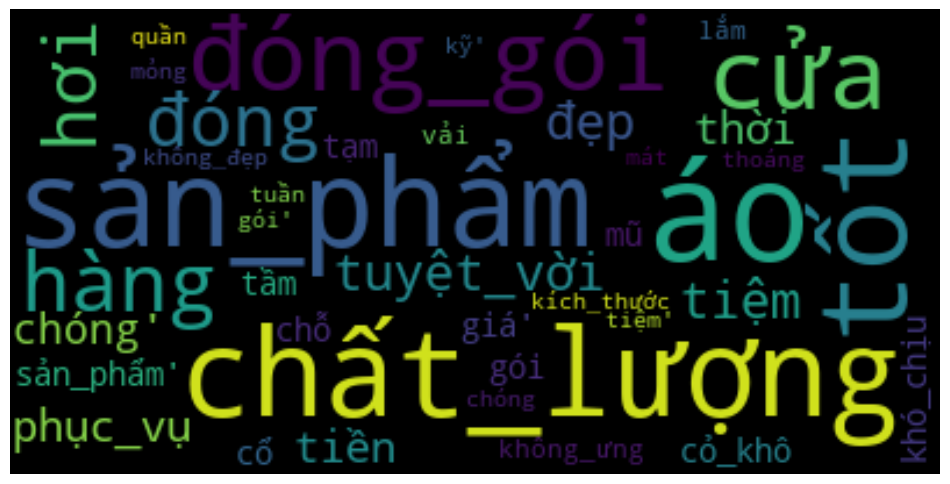

In [33]:
# display the word clouds
plt.figure(figsize=(12, 12))
plt.imshow(wc_like, interpolation='bilinear') 
plt.axis('off')
plt.show()

In [34]:
wc_notlike = WordCloud(background_color='black', max_words=500)
#generate the word cloud
wc_notlike.generate(str(df_sub_notlike['comment_new'].values))

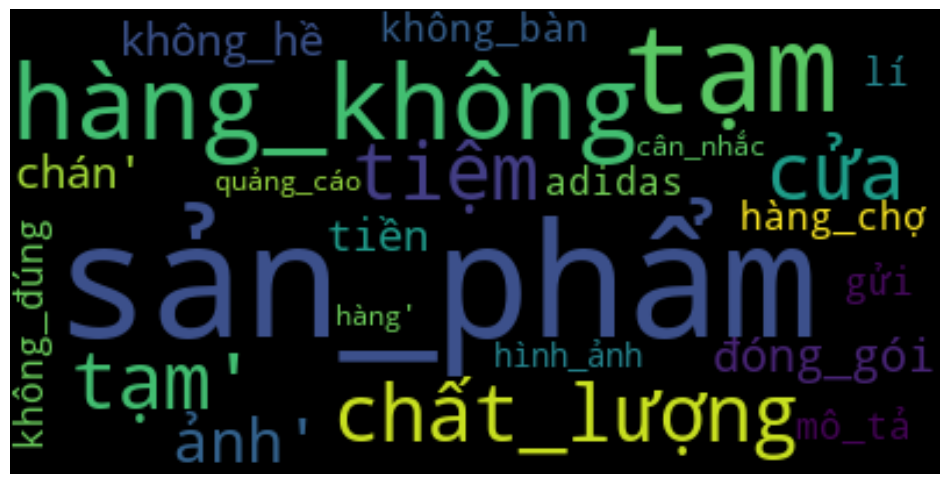

In [35]:
# display the word clouds
plt.figure(figsize=(12, 12))
plt.imshow(wc_notlike, interpolation='bilinear') 
plt.axis('off')
plt.show()